BerkeleyX: Data8.2x

Foundations of Data Science: Inferential Thinking by Resampling

In [1]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Lab 3: Inference and Capital Punishment, Part 1

Does instituting a death penalty as a punishment for murder actually reduce the number of murders?

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

In [2]:
murder_rates = Table.read_table('../../data/crime_rates.csv').select(
    'State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


1: Murder rates

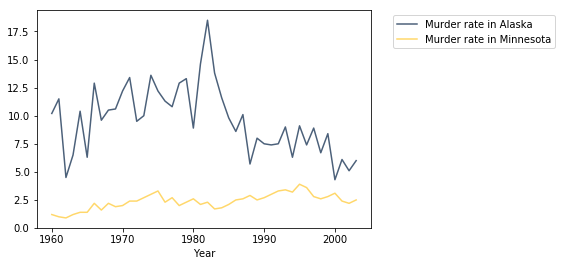

In [3]:
# Question 1.2. 
# Draw a line plot with years on the horizontal axis and murder rates on the vertical axis.
# Include two lines: one for Alaska murder rates and one for Minnesota murder rates.
# Create this plot using a single call, ak_mn.plot('Year').

ak = murder_rates.where('State', 'Alaska').drop('State', 'Population').relabeled(
    1, 'Murder rate in Alaska')
mn = murder_rates.where('State', 'Minnesota').drop('State', 'Population').relabeled(
    1, 'Murder rate in Minnesota')
ak_mn = ak.join('Year', mn)

ak_mn.plot('Year')

In [4]:
# interactive version of the above
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def state(state1, state2):
    s1 = murder_rates.where('State', state1).drop('State', 'Population').relabeled(
        1, 'Murder rate in {}'.format(state1))
    s2 = murder_rates.where('State', state2).drop('State', 'Population').relabeled(
        1, 'Murder rate in {}'.format(state2))
    s1_s2 = s1.join('Year', s2)
    s1_s2.plot('Year')
    plt.show()

states_array = murder_rates.group('State').column('State')

_ = interact(state,
             state1=widgets.Dropdown(options=list(states_array),value='California'),
             state2=widgets.Dropdown(options=list(states_array),value='New York')
            )

interactive(children=(Dropdown(description='state1', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachuse', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Isla', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'), value='California'), Dropdown(description='state2', index=31, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachuse', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Isla', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'), value='New York'), Output()), _dom_classes=('widget-interact',))

['California' 'Mississippi' 'Texas' 'New York' 'Louisiana']


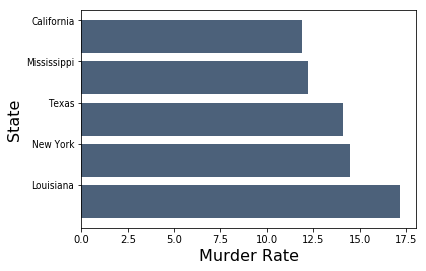

In [5]:
# Question 1.3
# most_murderous()
#  draws a horizontal bar chart of the 5 states that had the highest murder rates in that year
#  returns an array of the names of these states in order of increasing murder rate
def most_murderous(year):
    data_for_year = murder_rates.where('Year', year).drop(1, 2)
    sorted_data = data_for_year.sort(1, descending=True)
    top_5 = sorted_data.take[:5].sort(1)
    top_5.barh('State', 'Murder Rate')
    return top_5.column('State')

print(most_murderous(1990))

In [6]:
# Question 1.4
# How many more people were murdered in California in 1988 than in 1975?
ca = murder_rates.where('State', are.equal_to('California'))

def murdered(table, year):
    data = table.where('Year', year)
    pop = data[2][0]
    rate = data[3][0]
    return rate * pop / 100_000

ca_change = murdered(ca, 1988) - murdered(ca, 1975)
print(np.round(ca_change))

726.0


2: Changes in Murder Rates

Null hypothesis:
- For a set of U.S. states, the murder rate was equally likely to go up or down each year

In [7]:
# we need a variation on np.diff(), to compare against n neighbor
def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

diff_n(make_array(1, 10, 100, 1000, 10000), 2)

array([  99,  990, 9900])

In [8]:
# Question 2.1. 
# two_year_changes() from murder rates for a state, ordered by increasing year.
#  For all two-year periods (e.g., from 1960 to 1962),
#  it computes and returns the number of increases minus the number of decreases.

def two_year_changes(rates):
    "Return the number of increases minus the number of decreases after two years."
    deltas = diff_n(rates, 2)
    return np.count_nonzero(deltas > 0) - np.count_nonzero(deltas < 0)

print('Example', two_year_changes(make_array(10, 7, 12, 9, 13, 9, 11)), '(2 is expected)')
print('Alaska:',    two_year_changes(ak.column('Murder rate in Alaska')))
print('Minnesota:', two_year_changes(mn.column('Murder rate in Minnesota')))

Example 2 (2 is expected)
Alaska: -5
Minnesota: 6


In [9]:
# Question 2.2. 
# Assign changes_by_state to a table with one row per state that has two columns:
#  the State name
#  the Murder Rate two_year_changes statistic computed across all years in our data set for that state
states = murder_rates.group('State').column('State')
changes = []
for state in states:
    tab = murder_rates.where('State', state)
    changes.append(two_year_changes(tab.column('Murder Rate')))

changes_by_state = Table().with_columns(['State', states, 'Murder Rate two_year_changes', changes])
changes_by_state

State,Murder Rate two_year_changes
Alabama,-6
Alaska,-5
Arizona,1
Arkansas,-1
California,17
Colorado,-4
Connecticut,4
Delaware,-3
Florida,-6
Georgia,-3


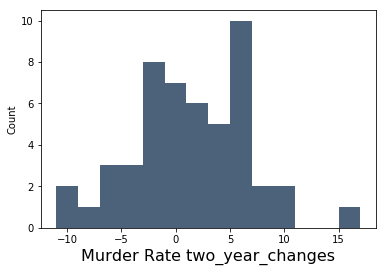

In [10]:
changes_by_state.hist("Murder Rate two_year_changes", bins=np.arange(-11, 19, 2), normed=None)

In [11]:
# Question 2.3. 
# Assign total_changes to the total increases minus the total decreases
#  for all two-year periods and all states in our data set.
# For example, if the murder rate in Ohio went up 23 times and fell 17 times,
#  the total change for Ohio would be 6.
# We want the total value for all the states together.

total_changes = sum(changes_by_state.column(1))
print('Total increases minus total decreases, across all states and years:', total_changes)

Total increases minus total decreases, across all states and years: 45


In [12]:
# Question 2.4. 
# What is the total number of distinct pairs of a state and a two-year period?

# For example, Alaska during 1968 to 1970 would count as one distinct pair.
# Considering all states and all possible two-year periods, how many such pairs are there in total?
len(states) * (max(murder_rates.column('Year')) - min(murder_rates.column('Year')) - 1)

2100

Null Hypothesis:
- State murder rates increase and decrease over two-year periods as if "increase" or "decrease" were sampled at random from a uniform distribution, like a fair coin flip.

Alternative Hypothesis:
- State murder rates are more likely to increase over two-year periods.

Test Statistic:
- The number of increases minus the number of decreases

In [13]:
uniform = Table().with_columns(
    "Change", make_array('Increase', 'Decrease'),
    "Chance", make_array(0.5,        0.5))
uniform.sample_from_distribution('Chance', 100)

Change,Chance,Chance sample
Increase,0.5,50
Decrease,0.5,50


In [14]:
# Question 2.5
# samples num_changes increases/decreases at random many times
# and forms an empirical distribution of your test statistic under the null hypothesis.
# simulate_under_null() simulates a single sample under the null hypothesis

def simulate_under_null(num_chances_to_change):
    """Simulates some number changing several times, with an equal
    chance to increase or decrease.  Returns the value of our
    test statistic for these simulated changes.
    
    num_chances_to_change is the number of times the number changes.
    """
    sample = uniform.sample_from_distribution('Chance', num_chances_to_change)
    return np.diff(sample.column(2))

repetitions = 5_000
uniform_samples = np.empty(repetitions)
for i in range(repetitions):
    uniform_samples[i] = simulate_under_null(100)

simulated_changes = Table().with_column('Test statistic under null', uniform_samples)
simulated_changes

Test statistic under null
-4
2
6
-18
-6
-10
26
2
-14
4


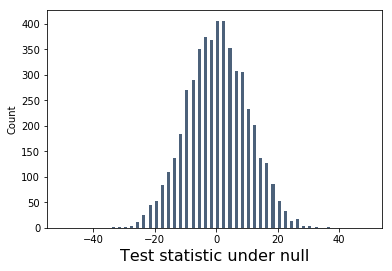

In [15]:
# simulated_changes.hist(0, bins=np.arange(-100, 400+25, 25), normed=None)
simulated_changes.hist(0, bins=range(-50, 50), normed=None)